In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.0738 - acc: 0.0957
Epoch 00001: val_loss improved from inf to 2.40933, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/001-2.4093.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 8.0735 - acc: 0.0957 - val_loss: 2.4093 - val_acc: 0.2250
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.3536 - acc: 0.1239
Epoch 00002: val_loss improved from 2.40933 to 2.14884, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/002-2.1488.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 5.3535 - acc: 0.1240 - val_loss: 2.1488 - val_acc: 0.3142
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3463 - acc: 0.5579
Epoch 00022: val_loss improved from 1.09729 to 1.05553, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/022-1.0555.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.3463 - acc: 0.5579 - val_loss: 1.0555 - val_acc: 0.6902
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3167 - acc: 0.5745
Epoch 00023: val_loss improved from 1.05553 to 1.04782, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/023-1.0478.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.3167 - acc: 0.5745 - val_loss: 1.0478 - val_acc: 0.6834
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2943 - acc: 0.5783
Epoch 00024: val_loss did not improve from 1.04782
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.2944 - acc: 0.5783 -

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0242 - acc: 0.6722
Epoch 00048: val_loss did not improve from 0.80439
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0243 - acc: 0.6722 - val_loss: 0.8480 - val_acc: 0.7601
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0233 - acc: 0.6713
Epoch 00049: val_loss improved from 0.80439 to 0.80387, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/049-0.8039.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0233 - acc: 0.6713 - val_loss: 0.8039 - val_acc: 0.7645
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0105 - acc: 0.6758
Epoch 00050: val_loss did not improve from 0.80387
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0105 - acc: 0.6758 - val_loss: 0.8095 - val_acc: 0.7538
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9155 - acc: 0.7071
Epoch 00076: val_loss did not improve from 0.69592
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.9159 - acc: 0.7071 - val_loss: 0.7054 - val_acc: 0.7932
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9146 - acc: 0.7086
Epoch 00077: val_loss did not improve from 0.69592
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.9145 - acc: 0.7086 - val_loss: 0.7152 - val_acc: 0.7990
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9132 - acc: 0.7102
Epoch 00078: val_loss did not improve from 0.69592
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.9131 - acc: 0.7102 - val_loss: 0.7351 - val_acc: 0.7880
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9114 - acc: 0.7117
Epoch 00079: val_loss did not improve from 0.69592
36805/36805 [===========

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8583 - acc: 0.7267
Epoch 00105: val_loss did not improve from 0.65854
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8586 - acc: 0.7267 - val_loss: 0.6726 - val_acc: 0.7952
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8567 - acc: 0.7271
Epoch 00106: val_loss improved from 0.65854 to 0.63165, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_3_conv_checkpoint/106-0.6316.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8567 - acc: 0.7271 - val_loss: 0.6316 - val_acc: 0.8120
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8483 - acc: 0.7312
Epoch 00107: val_loss did not improve from 0.63165
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8483 - acc: 0.7313 - val_loss: 0.7283 - val_acc: 0.7890
Epoch 108/500
36800/36805 [============================>.] - ETA:

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8085 - acc: 0.7420
Epoch 00134: val_loss did not improve from 0.60724
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8085 - acc: 0.7420 - val_loss: 0.7477 - val_acc: 0.7747
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8142 - acc: 0.7420
Epoch 00135: val_loss did not improve from 0.60724
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8144 - acc: 0.7420 - val_loss: 0.6335 - val_acc: 0.8127
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8097 - acc: 0.7413
Epoch 00136: val_loss did not improve from 0.60724
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8097 - acc: 0.7413 - val_loss: 0.6261 - val_acc: 0.8155
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8031 - acc: 0.7434
Epoch 00137: val_loss did not improve from 0.60724
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.7755 - acc: 0.7540
Epoch 00163: val_loss did not improve from 0.58642
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7754 - acc: 0.7541 - val_loss: 0.6037 - val_acc: 0.8195
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7741 - acc: 0.7548
Epoch 00164: val_loss did not improve from 0.58642
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7741 - acc: 0.7548 - val_loss: 0.6169 - val_acc: 0.8160
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7793 - acc: 0.7527
Epoch 00165: val_loss did not improve from 0.58642
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7792 - acc: 0.7528 - val_loss: 0.6268 - val_acc: 0.8116
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7751 - acc: 0.7553
Epoch 00166: val_loss did not improve from 0.58642
36805/36805 [=====================

Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7600 - acc: 0.7552
Epoch 00193: val_loss did not improve from 0.58642
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7600 - acc: 0.7553 - val_loss: 0.6283 - val_acc: 0.8076
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7491 - acc: 0.7611
Epoch 00194: val_loss did not improve from 0.58642
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7491 - acc: 0.7611 - val_loss: 0.6339 - val_acc: 0.8029
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7487 - acc: 0.7604
Epoch 00195: val_loss did not improve from 0.58642
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7486 - acc: 0.7605 - val_loss: 0.6675 - val_acc: 0.7957
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7496 - acc: 0.7622
Epoch 00196: val_loss did not improve from 0.58642
36805/36805 [=======

Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7340 - acc: 0.7666
Epoch 00222: val_loss did not improve from 0.56082
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7341 - acc: 0.7665 - val_loss: 0.6619 - val_acc: 0.8064
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7271 - acc: 0.7674
Epoch 00223: val_loss did not improve from 0.56082
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7271 - acc: 0.7674 - val_loss: 0.6346 - val_acc: 0.7959
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7247 - acc: 0.7672
Epoch 00224: val_loss did not improve from 0.56082
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7246 - acc: 0.7672 - val_loss: 0.5921 - val_acc: 0.8239
Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7241 - acc: 0.7697
Epoch 00225: val_loss did not improve from 0.56082
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.7035 - acc: 0.7749
Epoch 00251: val_loss did not improve from 0.55029
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7035 - acc: 0.7749 - val_loss: 0.6003 - val_acc: 0.8157
Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7124 - acc: 0.7721
Epoch 00252: val_loss did not improve from 0.55029
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7124 - acc: 0.7721 - val_loss: 0.6662 - val_acc: 0.7941
Epoch 253/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7093 - acc: 0.7732
Epoch 00253: val_loss did not improve from 0.55029
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7092 - acc: 0.7732 - val_loss: 0.6488 - val_acc: 0.7980
Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7080 - acc: 0.7745
Epoch 00254: val_loss did not improve from 0.55029
36805/36805 [=====================

Epoch 281/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6927 - acc: 0.7758
Epoch 00281: val_loss did not improve from 0.55029
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6928 - acc: 0.7757 - val_loss: 0.6033 - val_acc: 0.8102
Epoch 282/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6955 - acc: 0.7764
Epoch 00282: val_loss did not improve from 0.55029
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6955 - acc: 0.7764 - val_loss: 0.6234 - val_acc: 0.8139
Epoch 283/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6877 - acc: 0.7777
Epoch 00283: val_loss did not improve from 0.55029
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6877 - acc: 0.7777 - val_loss: 0.5964 - val_acc: 0.8204

1D_CNN_custom_multi_3_GMP_DO_BN_3_conv Model


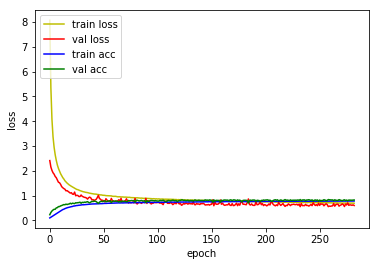

4815/4815 [==============================] - 3s 573us/sample - loss: 0.6149 - acc: 0.8135
Loss: 0.6149494808101456 Accuracy: 0.8134995

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.8663 - acc: 0.1134
Epoch 00001: val_loss improved from inf to 2.34869, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_4_conv_checkpoint/001-2.3487.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 6.8661 - acc: 0.1134 - val_loss: 2.3487 - val_acc: 0.2446
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8665 - acc: 0.1373
Epoch 00002: val_loss improved from 2.34869 to 2.01893, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_4_conv_checkpoint/002-2.0189.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 3.8665 - acc: 0.1373 - val_loss: 2.0189 - val_acc: 0.3860
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0659 - acc: 0.6589
Epoch 00023: val_loss improved from 0.73598 to 0.72439, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_4_conv_checkpoint/023-0.7244.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0660 - acc: 0.6589 - val_loss: 0.7244 - val_acc: 0.7969
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0360 - acc: 0.6696
Epoch 00024: val_loss improved from 0.72439 to 0.70103, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_4_conv_checkpoint/024-0.7010.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0359 - acc: 0.6696 - val_loss: 0.7010 - val_acc: 0.7983
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0224 - acc: 0.6737
Epoch 00025: val_loss did not improve from 0.70103
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0223 - acc: 0.6737 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7718 - acc: 0.7580
Epoch 00048: val_loss did not improve from 0.51941
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7718 - acc: 0.7580 - val_loss: 0.5315 - val_acc: 0.8519
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7617 - acc: 0.7607
Epoch 00049: val_loss did not improve from 0.51941
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7617 - acc: 0.7607 - val_loss: 0.5347 - val_acc: 0.8474
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7561 - acc: 0.7623
Epoch 00050: val_loss improved from 0.51941 to 0.50400, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_4_conv_checkpoint/050-0.5040.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7561 - acc: 0.7623 - val_loss: 0.5040 - val_acc: 0.8523
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.752

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6544 - acc: 0.7961
Epoch 00074: val_loss did not improve from 0.44588
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6544 - acc: 0.7961 - val_loss: 0.4902 - val_acc: 0.8609
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6464 - acc: 0.7994
Epoch 00075: val_loss did not improve from 0.44588
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6464 - acc: 0.7994 - val_loss: 0.4535 - val_acc: 0.8712
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6442 - acc: 0.7993
Epoch 00076: val_loss did not improve from 0.44588
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6445 - acc: 0.7992 - val_loss: 0.4517 - val_acc: 0.8668
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6552 - acc: 0.7961
Epoch 00077: val_loss did not improve from 0.44588
36805/36805 [===========

Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5697 - acc: 0.8221
Epoch 00102: val_loss did not improve from 0.40540
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5698 - acc: 0.8221 - val_loss: 0.4220 - val_acc: 0.8768
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5736 - acc: 0.8195
Epoch 00103: val_loss did not improve from 0.40540
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5735 - acc: 0.8195 - val_loss: 0.4111 - val_acc: 0.8803
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5770 - acc: 0.8201
Epoch 00104: val_loss did not improve from 0.40540
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5770 - acc: 0.8201 - val_loss: 0.4181 - val_acc: 0.8819
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5695 - acc: 0.8224
Epoch 00105: val_loss did not improve from 0.40540
36805/36805 [=======

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5262 - acc: 0.8366
Epoch 00130: val_loss did not improve from 0.38402
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5263 - acc: 0.8366 - val_loss: 0.4014 - val_acc: 0.8863
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5198 - acc: 0.8376
Epoch 00131: val_loss did not improve from 0.38402
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5197 - acc: 0.8377 - val_loss: 0.4191 - val_acc: 0.8758
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5140 - acc: 0.8380
Epoch 00132: val_loss did not improve from 0.38402
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5140 - acc: 0.8380 - val_loss: 0.4307 - val_acc: 0.8749
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5206 - acc: 0.8360
Epoch 00133: val_loss did not improve from 0.38402
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.4771 - acc: 0.8507
Epoch 00159: val_loss did not improve from 0.38130
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4771 - acc: 0.8507 - val_loss: 0.3895 - val_acc: 0.8873
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4848 - acc: 0.8479
Epoch 00160: val_loss did not improve from 0.38130
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4848 - acc: 0.8478 - val_loss: 0.3877 - val_acc: 0.8882
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4850 - acc: 0.8489
Epoch 00161: val_loss did not improve from 0.38130
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4849 - acc: 0.8489 - val_loss: 0.4045 - val_acc: 0.8798
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4828 - acc: 0.8489
Epoch 00162: val_loss improved from 0.38130 to 0.37811, saving model to model/checkpo

Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4494 - acc: 0.8582
Epoch 00188: val_loss did not improve from 0.37162
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4494 - acc: 0.8581 - val_loss: 0.4044 - val_acc: 0.8758
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4452 - acc: 0.8587
Epoch 00189: val_loss did not improve from 0.37162
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4453 - acc: 0.8586 - val_loss: 0.4056 - val_acc: 0.8805
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4483 - acc: 0.8593
Epoch 00190: val_loss did not improve from 0.37162
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4482 - acc: 0.8593 - val_loss: 0.4345 - val_acc: 0.8756
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4419 - acc: 0.8605
Epoch 00191: val_loss did not improve from 0.37162
36805/36805 [=======

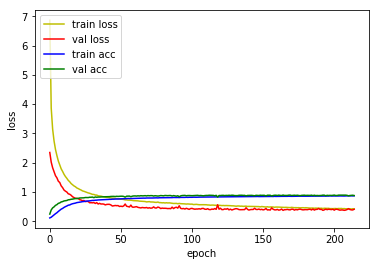

4815/4815 [==============================] - 3s 604us/sample - loss: 0.4311 - acc: 0.8644
Loss: 0.43113792689047126 Accuracy: 0.86438215

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.3839 - acc: 0.1406
Epoch 00001: val_loss improved from inf to 2.03206, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_5_conv_checkpoint/001-2.0321.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 5.3838 - acc: 0.1407 - val_loss: 2.0321 - val_acc: 0.2935
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0832 - acc: 0.2471
Epoch 00002: val_loss improved from 2.03206 to 1.34113, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_5_conv_checkpoint/002-1.3411.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 3.0834 - acc: 0.2470 - val_loss: 1.3411 - val_acc: 0.5928
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5368 - acc: 0.8319
Epoch 00024: val_loss improved from 0.31926 to 0.31710, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_5_conv_checkpoint/024-0.3171.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.5367 - acc: 0.8319 - val_loss: 0.3171 - val_acc: 0.9059
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5220 - acc: 0.8360
Epoch 00025: val_loss improved from 0.31710 to 0.30965, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_5_conv_checkpoint/025-0.3096.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.5220 - acc: 0.8360 - val_loss: 0.3096 - val_acc: 0.9059
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5100 - acc: 0.8432
Epoch 00026: val_loss did not improve from 0.30965
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5100 - acc: 0.8432 -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3530 - acc: 0.8923
Epoch 00050: val_loss improved from 0.23975 to 0.23417, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_5_conv_checkpoint/050-0.2342.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3530 - acc: 0.8924 - val_loss: 0.2342 - val_acc: 0.9306
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3497 - acc: 0.8925
Epoch 00051: val_loss did not improve from 0.23417
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3497 - acc: 0.8925 - val_loss: 0.2600 - val_acc: 0.9215
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3405 - acc: 0.8951
Epoch 00052: val_loss did not improve from 0.23417
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3404 - acc: 0.8952 - val_loss: 0.2410 - val_acc: 0.9290
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2665 - acc: 0.9173
Epoch 00078: val_loss did not improve from 0.20720
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2664 - acc: 0.9173 - val_loss: 0.2246 - val_acc: 0.9343
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2588 - acc: 0.9184
Epoch 00079: val_loss did not improve from 0.20720
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2588 - acc: 0.9184 - val_loss: 0.2084 - val_acc: 0.9394
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2625 - acc: 0.9180
Epoch 00080: val_loss did not improve from 0.20720
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2625 - acc: 0.9181 - val_loss: 0.2339 - val_acc: 0.9322
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9205
Epoch 00081: val_loss did not improve from 0.20720
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2125 - acc: 0.9324
Epoch 00106: val_loss did not improve from 0.19423
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2125 - acc: 0.9324 - val_loss: 0.2137 - val_acc: 0.9371
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9330
Epoch 00107: val_loss did not improve from 0.19423
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2092 - acc: 0.9331 - val_loss: 0.2043 - val_acc: 0.9399
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9336
Epoch 00108: val_loss did not improve from 0.19423
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2115 - acc: 0.9336 - val_loss: 0.2192 - val_acc: 0.9373
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2006 - acc: 0.9371
Epoch 00109: val_loss did not improve from 0.19423
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1721 - acc: 0.9448
Epoch 00135: val_loss did not improve from 0.19357
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1721 - acc: 0.9448 - val_loss: 0.1991 - val_acc: 0.9411
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9456
Epoch 00136: val_loss did not improve from 0.19357
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1705 - acc: 0.9455 - val_loss: 0.2085 - val_acc: 0.9401
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1918 - acc: 0.9383
Epoch 00137: val_loss did not improve from 0.19357
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1920 - acc: 0.9383 - val_loss: 0.2050 - val_acc: 0.9418
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1744 - acc: 0.9447
Epoch 00138: val_loss did not improve from 0.19357
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1467 - acc: 0.9534
Epoch 00164: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1467 - acc: 0.9534 - val_loss: 0.1994 - val_acc: 0.9432
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1402 - acc: 0.9540
Epoch 00165: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1402 - acc: 0.9539 - val_loss: 0.2056 - val_acc: 0.9434
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1463 - acc: 0.9525
Epoch 00166: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1462 - acc: 0.9525 - val_loss: 0.2096 - val_acc: 0.9441
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1419 - acc: 0.9543
Epoch 00167: val_loss did not improve from 0.19009
36805/36805 [=====================

Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1204 - acc: 0.9613
Epoch 00194: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1205 - acc: 0.9612 - val_loss: 0.2249 - val_acc: 0.9383
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1259 - acc: 0.9596
Epoch 00195: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1259 - acc: 0.9596 - val_loss: 0.2095 - val_acc: 0.9469
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9614
Epoch 00196: val_loss did not improve from 0.19009
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1215 - acc: 0.9614 - val_loss: 0.1983 - val_acc: 0.9443
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9613
Epoch 00197: val_loss did not improve from 0.19009
36805/36805 [=======

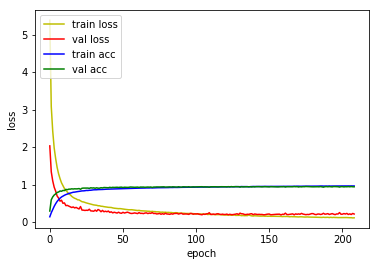

4815/4815 [==============================] - 3s 641us/sample - loss: 0.2205 - acc: 0.9327
Loss: 0.22053862863364374 Accuracy: 0.9327103

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4192 - acc: 0.2076
Epoch 00001: val_loss improved from inf to 1.59685, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_6_conv_checkpoint/001-1.5968.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 4.4193 - acc: 0.2076 - val_loss: 1.5968 - val_acc: 0.4854
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2638 - acc: 0.4225
Epoch 00002: val_loss improved from 1.59685 to 0.68053, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_6_conv_checkpoint/002-0.6805.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.2639 - acc: 0.4224 - val_loss: 0.6805 - val_acc: 0.7892
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2842 - acc: 0.9113
Epoch 00025: val_loss improved from 0.17495 to 0.16761, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_6_conv_checkpoint/025-0.1676.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.2843 - acc: 0.9113 - val_loss: 0.1676 - val_acc: 0.9490
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2719 - acc: 0.9145
Epoch 00026: val_loss improved from 0.16761 to 0.15554, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_6_conv_checkpoint/026-0.1555.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.2718 - acc: 0.9145 - val_loss: 0.1555 - val_acc: 0.9527
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2646 - acc: 0.9166
Epoch 00027: val_loss did not improve from 0.15554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2646 - acc: 0.9166 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1623 - acc: 0.9486
Epoch 00051: val_loss did not improve from 0.13236
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1623 - acc: 0.9485 - val_loss: 0.1489 - val_acc: 0.9585
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9507
Epoch 00052: val_loss did not improve from 0.13236
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1542 - acc: 0.9507 - val_loss: 0.1397 - val_acc: 0.9560
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1523 - acc: 0.9518
Epoch 00053: val_loss did not improve from 0.13236
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1523 - acc: 0.9518 - val_loss: 0.1388 - val_acc: 0.9562
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9525
Epoch 00054: val_loss improved from 0.13236 to 0.12839, saving model to model/checkpoint

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9694
Epoch 00080: val_loss did not improve from 0.12466
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0975 - acc: 0.9694 - val_loss: 0.1585 - val_acc: 0.9525
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9693
Epoch 00081: val_loss did not improve from 0.12466
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0936 - acc: 0.9693 - val_loss: 0.1498 - val_acc: 0.9590
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9704
Epoch 00082: val_loss did not improve from 0.12466
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0918 - acc: 0.9704 - val_loss: 0.1618 - val_acc: 0.9527
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0984 - acc: 0.9678
Epoch 00083: val_loss improved from 0.12466 to 0.12438, saving model to mod

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9786
Epoch 00109: val_loss did not improve from 0.12210
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0653 - acc: 0.9786 - val_loss: 0.1877 - val_acc: 0.9450
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9799
Epoch 00110: val_loss did not improve from 0.12210
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0632 - acc: 0.9799 - val_loss: 0.1607 - val_acc: 0.9525
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9801
Epoch 00111: val_loss did not improve from 0.12210
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0624 - acc: 0.9801 - val_loss: 0.1448 - val_acc: 0.9569
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9804
Epoch 00112: val_loss did not improve from 0.12210
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9858
Epoch 00138: val_loss did not improve from 0.12109
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0476 - acc: 0.9858 - val_loss: 0.1466 - val_acc: 0.9609
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9856
Epoch 00139: val_loss did not improve from 0.12109
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0462 - acc: 0.9856 - val_loss: 0.1473 - val_acc: 0.9611
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9856
Epoch 00140: val_loss did not improve from 0.12109
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0465 - acc: 0.9856 - val_loss: 0.1417 - val_acc: 0.9618
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9861
Epoch 00141: val_loss did not improve from 0.12109
36805/36805 [=====================

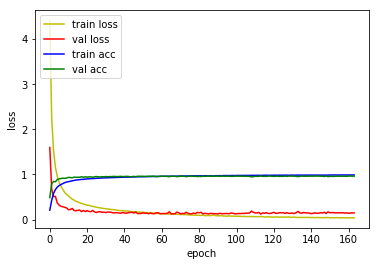

4815/4815 [==============================] - 3s 711us/sample - loss: 0.1525 - acc: 0.9574
Loss: 0.15246112532642894 Accuracy: 0.9574247

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3736 - acc: 0.3014
Epoch 00001: val_loss improved from inf to 1.37011, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_7_conv_checkpoint/001-1.3701.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 3.3735 - acc: 0.3015 - val_loss: 1.3701 - val_acc: 0.5628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4746 - acc: 0.5924
Epoch 00002: val_loss improved from 1.37011 to 0.42476, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_7_conv_checkpoint/002-0.4248.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.4746 - acc: 0.5924 - val_loss: 0.4248 - val_acc: 0.8677
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9456
Epoch 00025: val_loss did not improve from 0.12054
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1682 - acc: 0.9456 - val_loss: 0.1210 - val_acc: 0.9627
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1554 - acc: 0.9512
Epoch 00026: val_loss improved from 0.12054 to 0.11794, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_7_conv_checkpoint/026-0.1179.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1554 - acc: 0.9512 - val_loss: 0.1179 - val_acc: 0.9611
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1507 - acc: 0.9522
Epoch 00027: val_loss did not improve from 0.11794
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1507 - acc: 0.9522 - val_loss: 0.1251 - val_acc: 0.9632
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9797
Epoch 00053: val_loss did not improve from 0.09798
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0627 - acc: 0.9797 - val_loss: 0.1158 - val_acc: 0.9679
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9792
Epoch 00054: val_loss did not improve from 0.09798
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0653 - acc: 0.9792 - val_loss: 0.1375 - val_acc: 0.9592
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0732 - acc: 0.9768
Epoch 00055: val_loss did not improve from 0.09798
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0732 - acc: 0.9768 - val_loss: 0.1105 - val_acc: 0.9679
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9809
Epoch 00056: val_loss improved from 0.09798 to 0.09771, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9900
Epoch 00082: val_loss did not improve from 0.09771
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0314 - acc: 0.9900 - val_loss: 0.1348 - val_acc: 0.9630
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9895
Epoch 00083: val_loss did not improve from 0.09771
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0324 - acc: 0.9895 - val_loss: 0.1230 - val_acc: 0.9658
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9894
Epoch 00084: val_loss did not improve from 0.09771
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0324 - acc: 0.9894 - val_loss: 0.1221 - val_acc: 0.9676
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9895
Epoch 00085: val_loss did not improve from 0.09771
36805/36805 [========================

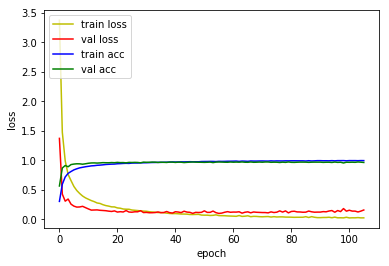

4815/4815 [==============================] - 4s 737us/sample - loss: 0.1355 - acc: 0.9603
Loss: 0.13549751874798308 Accuracy: 0.9603323

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5673 - acc: 0.3908
Epoch 00001: val_loss improved from inf to 1.02997, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_8_conv_checkpoint/001-1.0300.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 2.5673 - acc: 0.3908 - val_loss: 1.0300 - val_acc: 0.6690
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0226 - acc: 0.6956
Epoch 00002: val_loss improved from 1.02997 to 0.34749, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_BN_8_conv_checkpoint/002-0.3475.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.0227 - acc: 0.6956 - val_loss: 0.3475 - val_acc: 0.8917
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9722
Epoch 00025: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0857 - acc: 0.9722 - val_loss: 0.1414 - val_acc: 0.9597
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9734
Epoch 00026: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0819 - acc: 0.9734 - val_loss: 0.1164 - val_acc: 0.9665
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0806 - acc: 0.9736
Epoch 00027: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0805 - acc: 0.9736 - val_loss: 0.1130 - val_acc: 0.9676
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9755
Epoch 00028: val_loss did not improve from 0.10477
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9928
Epoch 00055: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0251 - acc: 0.9928 - val_loss: 0.1258 - val_acc: 0.9681
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0258 - acc: 0.9915 - val_loss: 0.1428 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9920
Epoch 00057: val_loss did not improve from 0.10477
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0265 - acc: 0.9919 - val_loss: 0.1255 - val_acc: 0.9658
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9888
Epoch 00058: val_loss did not improve from 0.10477
36805/36805 [===========

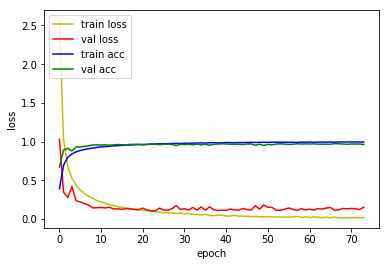

4815/4815 [==============================] - 4s 754us/sample - loss: 0.1537 - acc: 0.9526
Loss: 0.15368092314089693 Accuracy: 0.952648



In [10]:
base = '1D_CNN_custom_multi_3_GMP_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 811us/sample - loss: 0.4311 - acc: 0.8644
Loss: 0.43113792689047126 Accuracy: 0.86438215

1D_CNN_custom_multi_3_GMP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation

4815/4815 [==============================] - 4s 780us/sample - loss: 0.1525 - acc: 0.9574
Loss: 0.15246112532642894 Accuracy: 0.9574247

1D_CNN_custom_multi_3_GMP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 4s 850us/sample - loss: 0.1537 - acc: 0.9526
Loss: 0.15368092314089693 Accuracy: 0.952648


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 825us/sample - loss: 0.4676 - acc: 0.8528
Loss: 0.4676277162748953 Accuracy: 0.8527518

1D_CNN_custom_multi_3_GMP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation) 

4815/4815 [==============================] - 4s 909us/sample - loss: 0.1827 - acc: 0.9518
Loss: 0.18266370107041652 Accuracy: 0.9518172

1D_CNN_custom_multi_3_GMP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 5s 948us/sample - loss: 0.2269 - acc: 0.9491
Loss: 0.22694991009400795 Accuracy: 0.94911736
